### 必要モジュールのインポート

In [32]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import cv2
import copy
import random
import shutil
import kwcoco, kwplot, kwimage
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid

# 1枚の画像を表示する関数
def show_img(img, dpi=150, title=None):
    fig, ax = plt.subplots(nrows=1, ncols=1, dpi=dpi)
    ax.set_title( title, fontsize=16, color='black')
    ax.axis('off')
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return fig, ax

# 複数枚の画像を表示する関数
def show_imgs(imgs_dict:dict, ncol=0, dpi=200, font_scale=0.7):
    font_size = int(plt.rcParams["font.size"]*font_scale)

    if ncol > 0:
        nrow = ((len(imgs_dict)-1)//ncol)+1
    else:
        nrow = 1
        ncol = len(imgs_dict)

    img_num = len(imgs_dict)
    fig = plt.figure(figsize=(float(img_num), float(img_num)), dpi=dpi)
    grid = ImageGrid(fig, 111, nrows_ncols=(nrow, ncol), axes_pad=0.2,)

    for i in range(nrow*ncol):
        grid[i].axis('off')
        if i < len(imgs_dict):
            img_key = list(imgs_dict.keys())[i]
            grid[i].imshow(cv2.cvtColor(imgs_dict[img_key], cv2.COLOR_BGR2RGB))
            grid[i].set_title(img_key, fontsize=font_size, color='black', pad=int(font_size/2))
    
    plt.show(); plt.close()
    return None


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# kwcocoを拡張して、前処理画像を保存できるようにする
class kwcoco_cocodataset_wrapper(kwcoco.CocoDataset):
    def copy_dataset(self, dst, dataset_name=None, json_img_separate=False, img_dir_name="img", exist_ok=False):

        common_dir = max(list(set(Path(self.data_fpath).parents) & set((Path(self.data_root)/"_").parents)))
        if dataset_name is None:
            dataset_name = common_dir.name

        dst = Path(dst) / dataset_name
        if not dst.exists():
            dst.mkdir(parents=True)
        elif dst.exists() and exist_ok:
            shutil.rmtree(dst)
            dst.mkdir(parents=True)
        elif not exist_ok:
            raise Exception("exist_ok = False")

        new_json_path = None; new_img_root = None
        if json_img_separate:
            new_json_path = dst / Path(self.data_fpath).name
            new_img_root = dst / img_dir_name
            if not new_img_root.exists():
                new_img_root.mkdir(parents=True)

        else:
            new_json_path = dst / Path(self.data_fpath).name
            new_img_root = dst

        # copy json
        shutil.copyfile(self.data_fpath, new_json_path)
        # copy img data
        for src in tqdm(self.imgs, desc="COPY"):
            img_fname = self.imgs[src]["file_name"]
            shutil.copy(Path(self.img_root)/img_fname, new_img_root/img_fname)
        new_coco = kwcoco_cocodataset_wrapper(data=new_json_path, img_root=new_img_root)

        if json_img_separate:
            new_coco.reroot(new_prefix=img_dir_name)
        else:
            new_coco.reroot()

        return new_coco
    
    def __preprocessing(self):
        # TODO: 画像を前処理する
        return

    def preprocessing_imgData(self, func):
        for imgId in self.imgs:
            img = self.load_image(imgId)
            img = func(img)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # 上書き
            cv2.imwrite(str(Path(self.img_root)/self.imgs[imgId]["file_name"]), img)
        return
    
    def preprocessing_crop_img(self, width, height, center=(0,0)):
        # TODO: 画像から指定範囲を切り抜く
        return
    
    def preprocessing_resize_img(self, raito:float=1.0):
        # TODO: 画像を指定のサイズに拡大・縮小する
        
        for imgId in self.imgs:
            img = self.load_image(imgId)
            kw_img = self.coco_image(imgId)
            print(kw_img)
            kw_img.add_asset(img)
            break


            # org_height, org_width = img.shape[:2]
            # org_file_name = self.imgs[imgId]["file_name"]

            # # 画像について
            # resized_img = cv2.resize(src=img, dsize=None, fx=raito, fy=raito)
            # self.remove_images([imgId])
            # new_imgId = self.add_image(org_file_name)





        return

def change_color(src_img:np.ndarray):
    res_img = cv2.blur(src_img, (25,25) )
    return res_img

coco_path = Path("./__datasets__/sample_coco_train2017/instances_train2017.json")
coco_img_root = Path("./__datasets__/sample_coco_train2017/")

coco = kwcoco_cocodataset_wrapper(data=coco_path, img_root=coco_img_root)
coco = coco.copy_dataset(dst="./output/", json_img_separate=False, exist_ok=True)

coco.preprocessing_imgData(change_color)
coco.preprocessing_resize_img(raito=0.1)



# print(coco)

# raw_img = coco.load_image(random.choice(list(coco.imgs.keys())))
# show_img(raw_img)
# res_img = change_color(raw_img)
# show_img(res_img)



COPY: 100%|██████████| 100/100 [00:00<00:00, 1351.39it/s]


<CocoImage(wh=(640, 480),n_chan=AttributeErro~87e6~ute 'numel'"),channels=None)>


ValueError: Unable to infer aux_to_img without width

### データセットを読み込む

In [5]:
coco_path = Path("../__datasets__/sample_coco_train2017/instances_train2017.json")
coco_img_root = Path("../__datasets__/sample_coco_train2017/")

coco = kwcoco.CocoDataset(data=coco_path, img_root=coco_img_root)

print(coco)

<CocoDataset(tag=instances_train2017.json, n_anns=712, n_imgs=100, n_videos=0, n_cats=80)>


### 画像の前処理を行う

In [29]:
# 画像のサンプルIDを取得
sample_imgId = random.choice(list(coco.imgs.keys()))
print(f"image ID : {sample_imgId}")

coco_image = coco.coco_image(sample_imgId)
print(coco_image.wa)
print(coco_image.stats())
print(dir(coco_image))

coco.add_annotation()
coco.remove_annotation()
coco.add_image()
coco.add_images()

image ID : 188053
{'wh': (640, 478), 'n_chan': 'AttributeError("\'NoneType\' object has no attribute \'numel\'")', 'channels': None}
['__alias_to_aliases__', '__alias_to_primary__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__json__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__nice__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_annot_segmentation', '_assets_key', '_bundle_dpath', '_detections_for_resolution', '_proxy', '_scalefactor_for_resolution', '_video', 'add_annotation', 'add_asset', 'add_auxiliary_item', 'annots', 'assets', 'bundle_dpath', 'channels', 'datetime', 'delay', 'detach', 'draw', 'dset', 'dsize', 'find_asset_obj', 'from_gid', 'get', 'imdelay', 'img', 'i

In [ ]:
# 前処理を行う関数
def preprocessing_img(src_img:np.ndarray):
    res_img = src_img
    return res_img



(0.5, 1.5)


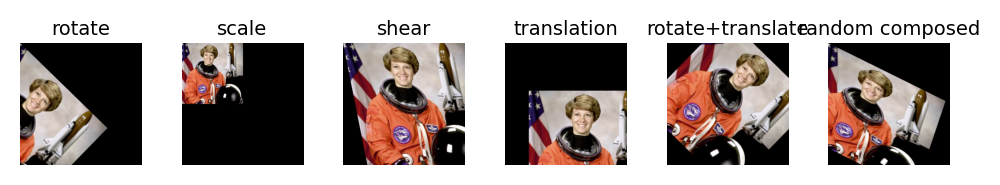

In [13]:
import kwimage
import math

image = kwimage.grab_test_image()
theta = 0.123 * math.tau
components = {
    'rotate': kwimage.Affine.affine(theta=theta),
    'scale': kwimage.Affine.affine(scale=0.5),
    'shear': kwimage.Affine.affine(shearx=0.2),
    'translation': kwimage.Affine.affine(offset=(100, 200)),
    'rotate+translate': kwimage.Affine.affine(theta=0.123 * math.tau, about=(256, 256)),
    'random composed': kwimage.Affine.random(scale=(0.5, 1.5), translate=(-20, 20), theta=(-theta, theta), shearx=(0, .4), rng=900558176210808600),
}

imgs = {}
for key, aff in components.items():
    imgs[key] = cv2.cvtColor(kwimage.warp_affine(image, aff), cv2.COLOR_BGR2RGB)


show_imgs(imgs)

In [25]:
from kwcoco.examples.simple_kwcoco_torch_dataset import *  # NOQA
import kwcoco
coco_dset = kwcoco.CocoDataset.demo('shapes8')
input_dims = (384, 384)


torch_dset = KWCocoSimpleTorchDataset(coco_dset, input_dims=input_dims)
print(dir(torch_dset))



[cacher] tryload fname=toy_dset_stamp_v020
[cacher] ... toy_dset_stamp_v020 cache hit
read dset_fpath = 'C:\\Users\\hirahara\\AppData\\Local\\kwcoco\\demodata_bundles\\shapes_8_iocrbdmcdmgxqk\\data.kwcoco.json'
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'antialias', 'augment', 'classes', 'coco_dset', 'gids', 'input_dims', 'rng']
